In [1]:
from IPython.display import display, HTML
display(HTML("""
<style>
div.container{width:90% !important;}
div.cell.code_cell.rendered{width:90%;}
div.input_prompt{padding:0px;}
div.CodeMirror {font-family:Consolas; font-size:10pt;}
div.text_cell_render.rendered_html{font-size:11pt;}
div.output {font-size:10pt; font-weight:bold;}
div.input {font-family:Consolas; font-size:10pt;}
div.prompt {min-width:70px;}
div#toc-wrapper{padding-top:120px;}
div.text_cell_render ul li{font-size:10pt;padding:5px;}
table.dataframe{font-size:10px;}
</style>
"""))

<b><font size="6" color="red">Ch.5 LSTM(Long Short-term Memory)</font><b>
- RNN의 일종
- IMDb 사이트의 영화 감상평 5만 개: Train/Test 데이터 
- 타깃변수: 부정(0)/긍정(1)

# 1. 패키지 import

In [13]:
import numpy as np
from tensorflow.keras.datasets import imdb
from tensorflow.keras.preprocessing.sequence import pad_sequences
from time import time
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, GRU, Dense
from sklearn.metrics import confusion_matrix, recall_score, precision_score, f1_score
import pandas as pd

# 2. 하이퍼파라미터 설정
- 하이퍼파라미터를 바꾸면 모델의 정확도나 속도에 차이

In [3]:
MY_WORDS = 10000 # imdb 데이터 안의 단어 수
MY_LENGTH = 80 # 독립변수 차원(영화평 단어수 80개로 맞출 예정)
MY_EMBED = 32 # Embedding 결과 차원
MY_HIDDEN = 64 # LSTM의 units수
MY_EPOCH = 10 # fit 학습 반복 수
MY_BATCH = 200 # 배치사이즈(fit할 때, 매번 가져오는 데이터 수)

# 3. 데이터 불러오기

In [5]:
(X_train, y_train), (X_test, y_test) = imdb.load_data(num_words=MY_WORDS) # 10000개만 숫자로 가져오고, 나머지는 2로 분류

In [12]:
print('학습용 독립변수 모양:', X_train.shape)
print('학습용 타깃변수 모양:', y_train.shape)
print('학습용 독립변수 샘플:', type(X_train), X_train[0][:80]) #넘파이 배열인데, 배열 안에 리스트로 담김
print('학습용 타갓변수 샘플:', type(y_train), y_train[0]) # 0: 부정, 1: 긍정
print('테스트용 독립변수 모양:', X_test.shape)
print('테스트용 타깃변수 모양:', y_test.shape)

학습용 독립변수 모양: (25000,)
학습용 타깃변수 모양: (25000,)
학습용 독립변수 샘플: <class 'numpy.ndarray'> [1, 14, 22, 16, 43, 530, 973, 1622, 1385, 65, 458, 4468, 66, 3941, 4, 173, 36, 256, 5, 25, 100, 43, 838, 112, 50, 670, 2, 9, 35, 480, 284, 5, 150, 4, 172, 112, 167, 2, 336, 385, 39, 4, 172, 4536, 1111, 17, 546, 38, 13, 447, 4, 192, 50, 16, 6, 147, 2025, 19, 14, 22, 4, 1920, 4613, 469, 4, 22, 71, 87, 12, 16, 43, 530, 38, 76, 15, 13, 1247, 4, 22, 17]
학습용 타갓변수 샘플: <class 'numpy.ndarray'> 1
테스트용 독립변수 모양: (25000,)
테스트용 타깃변수 모양: (25000,)


In [18]:
# 부정/긍정 비율 확인(타깃변수 균형)
print('y_train \n', pd.Series(y_train).value_counts())
print('y_test \n', pd.Series(y_test).value_counts())

y_train 
 1    12500
0    12500
dtype: int64
y_test 
 0    12500
1    12500
dtype: int64


In [19]:
# 긍정 갯수
print('학습데이터의 긍정 갯수: ', y_train.sum())
print('테스트데이터의 긍정 갯수: ', y_test.sum())

학습데이터의 긍정 갯수:  12500
테스트데이터의 긍정 갯수:  12500


# 4. 문자 단어 → 정수

In [24]:
word_to_id = imdb.get_word_index() #빈도가 높은 단어는 앞으로
print(word_to_id['movie'])
print(word_to_id['film'])
print(word_to_id['the'])
# 정수 → 문자 단어
id_to_word = {} # 정수(id) : 문자단어
for key, value in  word_to_id.items():
    id_to_word[value] = key
print(id_to_word[17])
print(id_to_word[19])
print(id_to_word[1])

17
19
1
movie
film
the


In [27]:
msg = "What a wonderful moviee" # 없는 단어 어떻게 하나 보자. 일부러 오타
msg = msg.lower().split()
print(msg)
# 1: 리뷰의 시작을 알리는 숫자
# 2: MY_WORDS 안에 들어가지 않는 단어
# 3: padding 처리
data = [1] + [word_to_id.get(m, -1)+3 for m in msg]
print('원 후기 내용: ', msg)
print('encoded된 내용(data): ', data)
print('data 추정: ', ' '.join([id_to_word.get(d-3, '???') for d in data]))

['what', 'a', 'wonderful', 'moviee']
원 후기 내용:  ['what', 'a', 'wonderful', 'moviee']
encoded된 내용(data):  [1, 51, 6, 389, 2]
data 추정:  ??? what a wonderful ???


# 5. 숫자 영화평 → 자연어 영화평 함수

In [28]:
def decoding(review_nums):
    decoded = [] #숫자를 단어로 해석한 내용 append 예정
    for num in review_nums:
        word = id_to_word.get(num - 3, '???')
        decoded.append(word)
    print(' '.join(decoded))

In [29]:
decoding(X_train[0]), y_train[0]

??? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ??? is an amazing actor and now the same being director ??? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as soon as it was released for ??? and would recommend it to everyone to watch and the fly fishing was amazing really cried at the end it was so sad and you know what they say if you cry at a film it must have been good and this definitely was also ??? to the two little boy's that played the ??? of norman and paul they were just brilliant children are often left out of the ??? list i think because the stars that play them all grown up are such a big profile for the whole film but these children are amazing and should be praised for what they have done

(None, 1)

In [30]:
decoding(X_test[0]), y_test[0]

??? please give this one a miss br br ??? ??? and the rest of the cast rendered terrible performances the show is flat flat flat br br i don't know how michael madison could have allowed this one on his plate he almost seemed to know this wasn't going to work out and his performance was quite ??? so all you madison fans give this a miss


(None, 0)

# 6. 영화평 학습용 데이터 처음 10개의 길이 출력 함수

In [33]:
def show_length():
    print('첫 10개 영화평 길이')
#     for i in range(11):
#         print(f'{i}번째 길이: {len(X_train[i])}')
    print([len(x) for x in X_train[:10]])
show_length()

첫 10개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130]


In [34]:
print('pad_sequence 작업 전')
show_length()

pad_sequence 작업 전
첫 10개 영화평 길이
[218, 189, 141, 550, 147, 43, 123, 562, 233, 130]


In [35]:
# X_train 후기 중 가장 긴 단어수, 가장 짧은 단어수
max ([len(x) for x in X_train]), min([len(x) for x in X_train])

(2494, 11)

# 7. 모든 영화평의 길이를 동일하게 (MY_LENGTH만큼)
- 1 post 자르기, post 붙이기 : 0.7542799711227417 #.3
- 2 post 자르기, pre 붙이기 : 0.7525200247764587 #.4
- 3 pre 자르기, post 붙이기 : 0.7577599883079529 #.1
- 4 pre 자르기, pre 붙이기 : 0.7569199800491333 #.2

In [62]:
X_train = pad_sequences(X_train, 
                        maxlen=MY_LENGTH, 
                        truncating='pre', # 지정한 단어수(80) 이상일 경우 어디를 자를지
                        padding='pre' # 짧을 경우 앞/뒤에 zero를 붙임
                       ) 
X_test = pad_sequences(X_test, 
                        maxlen=MY_LENGTH, 
                        truncating='pre', # 지정한 단어수(80) 이상일 경우 어디를 자를지
                        padding='pre' # 짧을 경우 앞/뒤에 zero를 붙임
                       )
show_length()

첫 10개 영화평 길이
[80, 80, 80, 80, 80, 80, 80, 80, 80, 80]


# 8. 최종 데이터 shape 확인

In [47]:
X_train.shape, y_train.shape, X_test.shape, y_test.shape

((25000, 80), (25000,), (25000, 80), (25000,))

In [48]:
decoding(X_train[0])

??? this film was just brilliant casting location scenery story direction everyone's really suited the part they played and you could just imagine being there robert ??? is an amazing actor and now the same being director ??? father came from the same scottish island as myself so i loved the fact there was a real connection with this film the witty remarks throughout the film were great it was just brilliant so much that i bought the film as


# 9. 모델 생성 및 구현

In [63]:
model = Sequential()
model.add(Embedding(input_dim=MY_WORDS, #10000
                    output_dim=MY_EMBED, #32
                    input_length=MY_LENGTH, #80
                   ))
model.add(LSTM(units=MY_HIDDEN, #64
               input_shape=(MY_LENGTH, MY_EMBED), 
               # kernel_initializer='he_normal' #입력가중치 초기화
               # recurrent_initializer='orthogonal' #순환가중치 초기화
              ))
model.add(Dense(units=1, activation='sigmoid'))
model.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_3 (Embedding)     (None, 80, 32)            320000    
                                                                 
 lstm_3 (LSTM)               (None, 64)                24832     
                                                                 
 dense_3 (Dense)             (None, 1)                 65        
                                                                 
Total params: 344,897
Trainable params: 344,897
Non-trainable params: 0
_________________________________________________________________


# 10. 학습환경 설정 및 학습하기

In [64]:
model.compile(loss='binary_crossentropy', #이중분류(로지스틱회귀분석)
              optimizer='adam',
              metrics=['acc'])
start = time() # 70.1.1 유닉스 타임
hist = model.fit(X_train, y_train, 
                 epochs=MY_EPOCH, 
                 batch_size=MY_BATCH, 
                 validation_split=0.2, 
                 verbose=1)
end = time()
print('총 fit 시간: {:.5f}'.format(end-start))

Epoch 1/10
100/100 [==============================] - 8s 75ms/step - loss: 0.5784 - acc: 0.6773 - val_loss: 0.4284 - val_acc: 0.8072
Epoch 2/10
100/100 [==============================] - 7s 69ms/step - loss: 0.3575 - acc: 0.8512 - val_loss: 0.4094 - val_acc: 0.8186
Epoch 3/10
100/100 [==============================] - 7s 70ms/step - loss: 0.2789 - acc: 0.8896 - val_loss: 0.4457 - val_acc: 0.8090
Epoch 4/10
100/100 [==============================] - 7s 71ms/step - loss: 0.2336 - acc: 0.9111 - val_loss: 0.4572 - val_acc: 0.8050
Epoch 5/10
100/100 [==============================] - 7s 70ms/step - loss: 0.1969 - acc: 0.9306 - val_loss: 0.4680 - val_acc: 0.7986
Epoch 6/10
100/100 [==============================] - 7s 70ms/step - loss: 0.1740 - acc: 0.9404 - val_loss: 0.5697 - val_acc: 0.7984
Epoch 7/10
100/100 [==============================] - 7s 70ms/step - loss: 0.1607 - acc: 0.9457 - val_loss: 0.5793 - val_acc: 0.7898
Epoch 8/10
100/100 [==============================] - 7s 70ms/step - 

In [59]:
hist.history.keys()

dict_keys(['loss', 'acc', 'val_loss', 'val_acc'])

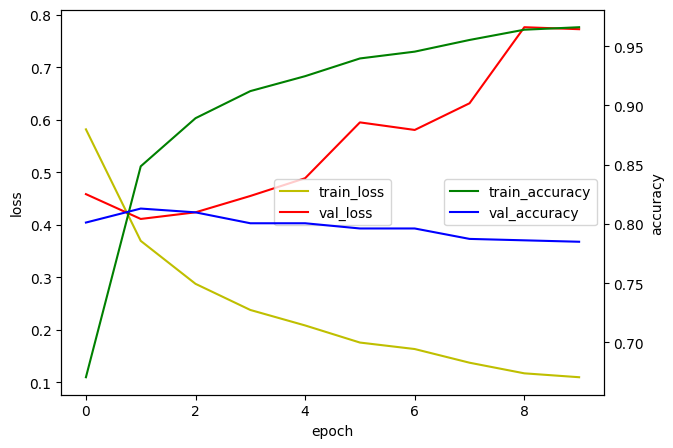

In [43]:
# 시각화 1
import matplotlib.pyplot as plt
fig, loss_ax = plt.subplots(figsize=(7,5))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [41]:
# 테스트 데이터로 평가 1
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('test의 데이터 정확도: ', acc)

test의 데이터 정확도:  0.7542799711227417


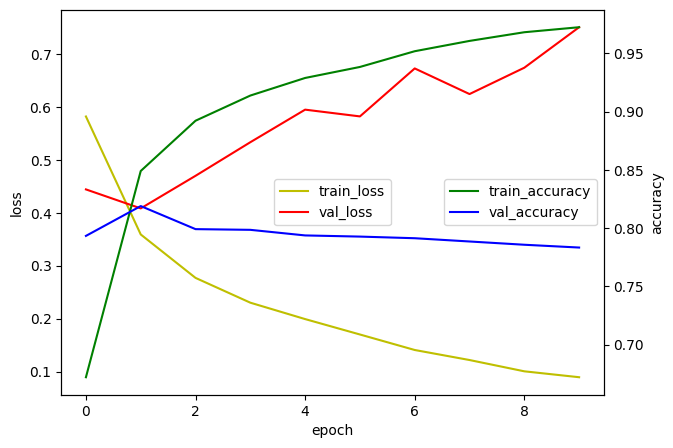

In [51]:
# 시각화 2
fig, loss_ax = plt.subplots(figsize=(7,5))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [52]:
# 테스트 데이터로 평가 2
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('test의 데이터 정확도: ', acc)

test의 데이터 정확도:  0.7525200247764587


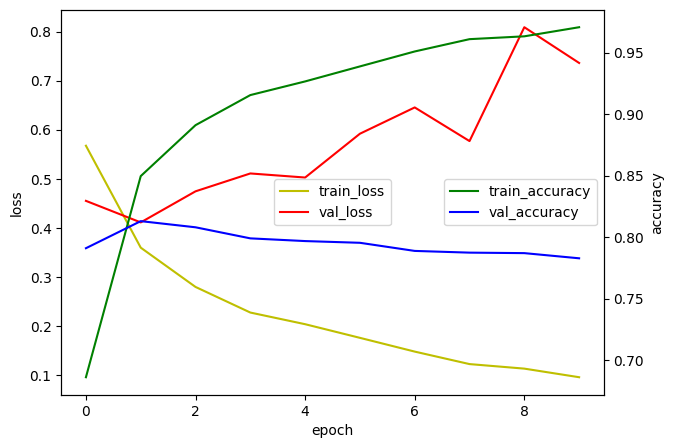

In [60]:
# 시각화 3
fig, loss_ax = plt.subplots(figsize=(7,5))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [61]:
# 테스트 데이터로 평가 3
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('test의 데이터 정확도: ', acc)

test의 데이터 정확도:  0.7577599883079529


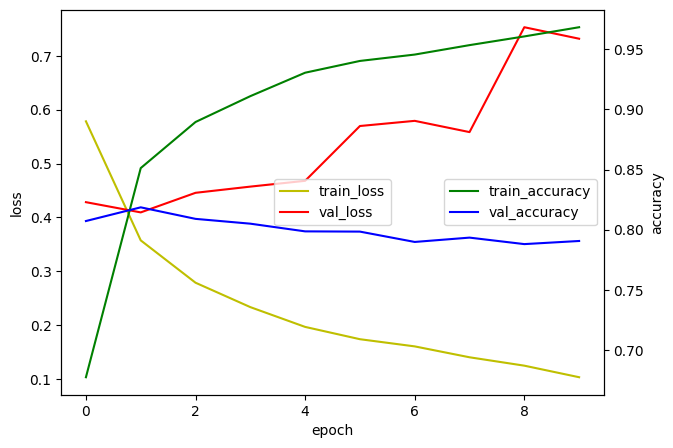

In [65]:
# 시각화 4
fig, loss_ax = plt.subplots(figsize=(7,5))
loss_ax.plot(hist.history['loss'], 'y', label='train_loss')
loss_ax.plot(hist.history['val_loss'], 'r', label='val_loss')
acc_ax = loss_ax.twinx()
acc_ax.plot(hist.history['acc'], 'g', label='train_accuracy')
acc_ax.plot(hist.history['val_acc'], 'b', label='val_accuracy')
loss_ax.set_xlabel('epoch')
loss_ax.set_ylabel('loss')
acc_ax.set_ylabel('accuracy')
loss_ax.legend(loc='center')
acc_ax.legend(loc='center right')
plt.show()

In [66]:
# 테스트 데이터로 평가 4
loss, acc = model.evaluate(X_test, y_test, verbose=0)
print('test의 데이터 정확도: ', acc)

test의 데이터 정확도:  0.7569199800491333


1. post 자르기, post 붙이기 : 0.7542799711227417 #.3
2. post 자르기, pre 붙이기 : 0.7525200247764587 #.4
3. pre 자르기, post 붙이기 : 0.7577599883079529 #.1
4. pre 자르기, pre 붙이기 : 0.7569199800491333 #.2